# Forward Propagation Code for a Sphere


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as linalg
import copy
import itertools
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [4]:
def refract(n, r, R, l):
    '''
    Inputs:
    n (array of three elements): normal vector at incident point of light vector
    r (float): refractive index ratio
    R (float): radius of sphere
    l (array of three elements): incident light vector
    
    Returns:
    v_refract (array of three elements): refracted light vector
    '''
    
    # Implement Snell's Law
    c = 0-np.dot(n, l)
    temp = 1-(r**2)*(1-(c**2))
    if temp < 0:
        return -1
    A = (r*c - np.sqrt(temp))/R
    v_refract = r*np.array([0,0,1]) + A*n
    return v_refract

def reflect(n, nu1, nu2, l):
    '''
    Inputs:
    n (vector): normal vector
    nu1 (float):
    nu2 (float):
    l (array of three elements): incident light vector
    
    Returns:
    T (float): Transmittance as a percentage of original intensity
    '''
    theta_i = 0-np.dot(n, l)
    theta_t =  np.arcsin(np.sqrt(((nu1/nu2)**2)*(1-(np.cos(theta_i))**2)))
    
    R_perp = ((nu1*np.cos(theta_i) - nu2*np.cos(theta_t))/(nu1*np.cos(theta_i) + nu2*np.cos(theta_t)))**2
    R_para = ((nu2*np.cos(theta_i) - nu1*np.cos(theta_t))/(nu2*np.cos(theta_i) + nu1*np.cos(theta_t)))**2
    R = 0.5*(R_perp + R_para)
    T = 1 - R
    return T

def get_ray(R, x, y, nu1, nu2, suppress=True):
    
    '''
    Inputs:
    R (float): radius
    x (float): x-coordinate, less than R
    y (float): y-coordinate, less than R
    r (float): refractive index ratio
    suppress (bool): Suppresses print statements
    
    Returns:
    array (array of seven elements): exiting light vector, path length, and exit point
    '''
    
    # Get z coordinate and entry point
    z_sq = np.square(R)-np.square(x)-np.square(y)
    if z_sq < 0:
         return np.array([0,0,1,float('inf'),x,y,0,1,1])
    z = -np.sqrt(z_sq)
    entry_point = np.array([x,y,z])
    if not suppress:
        print("The entry point is",  entry_point)
        
    # Get surface normal vector
    n_in = np.array([x/R,y/R,z/R])
    if not suppress:
        print("The normalised entry vector is", n_in)
    
    ## Get entry transmittance factor and the first refraction vector
    transmit1 = reflect(n_in, nu1, nu2, np.array([0,0,1])) 
    v_refract1 = refract(n_in, r, R, np.array([0,0,1]))
    
    # if v_refract1 is erroneous (due to TIR), return the trivial vector (0,0,1), 'inf' and the entry point
    if type(v_refract1) == int:
        return np.array([0,0,1,float('inf'),x,y,z,1,1])
    
    # Normalize v_refract1
    v_refract1 = v_refract1/linalg.norm(v_refract1)
    if not suppress:
        print("v_refract1 is", v_refract1)
        print(linalg.norm(v_refract1))
    
    # Some analytical expression for t: the depth parameter
    t = 0 - (2*np.dot(entry_point, v_refract1))/np.dot(v_refract1, v_refract1)
    if not suppress:
        print("t is", t)
    
    # Eqn of a ray through the sphere
    exit_point = entry_point + t*v_refract1
    if not suppress:
        print("The exit point is", exit_point)
        print("The magnitude of the exit point is", exit_point[0]**2 + exit_point[1]**2 + exit_point[2]**2)
    
    # Get normal vector at exit point
    n_out = 0 - exit_point/linalg.norm(exit_point)
    if not suppress:
        print("The normalised exit vector is", n_out)
    
    # Get exit transmittance factor and the second refraction vector
    transmit2 = reflect(n_out, nu2, nu1, np.array([0,0,1])) 
    v_refract2 = refract(n_out, 1/r, R, v_refract1)
    
    # if v_refract2 is erroneous (due to TIR), return the trivial vector (0,0,1), 'inf' and the exit point
    if type(v_refract2) == int:
        return np.array([0,0,1,float('inf'),x,y,exit_point[2],1,1])
    v_refract2 = v_refract2/linalg.norm(v_refract2)
    
    # Append t and entry_point to v_refract2 to get an array of seven elements
    array = np.append(v_refract2, t)
    array = np.concatenate([array, exit_point])
    array = np.concatenate([array, [transmit1, transmit2]])
    return array

def create_matrix(grid_params, R, nu1, nu2):
    
    '''
    grid_params (array of six elements): min_x, max_x, min_y, max_y, sampling points along x and y axes
    R (float): Radius of sphere
    r (float): refractive index ratio
    '''
    
    min_x, max_x, min_y, max_y, points_x, points_y = grid_params
    data = np.zeros((9,points_x,points_y))
    x_axis = np.linspace(min_x, max_x, points_x)
    y_axis = np.linspace(min_y, max_y, points_y)
    for i in range(points_x):
        for j in range(points_y):
            ans = get_ray(R,x_axis[i],y_axis[j],nu1,nu2)
            for k in range(9):
                data[k][i][j] = ans[k]
    return data

def screen(intensity, matrix, distance, beta, R, grid_params):
    
    '''
    grid_params (array of six elements): same as above
    intensity (float): intensity of light ray after attenuation
    matrix (3d matrix): Matrix of light vector + path length for each x, y
    distance (float): distance to screen
    '''
    
    data2 = copy.deepcopy(data)
    min_x, max_x, min_y, max_y, points_x, points_y = grid_params

    # Attenuate light
    data2[3][:][:] = data2[7][:][:]*data2[8][:][:]*np.exp(4*np.pi*(-beta)*data2[3][:][:])
    
    # Calculate distance in z-direction of each ray from screen
    distance_from_screen = distance + R - data[6][:][:]
 
    # Find x and y distances travelled by each ray from individual exit point to screen
    data2[0][:][:] = data2[4][:][:] + distance_from_screen*np.divide(data2[0][:][:], data2[2][:][:])
    data2[1][:][:] = data2[5][:][:] + distance_from_screen*np.divide(data2[1][:][:], data2[2][:][:])
    data2[2][:][:] = 1
    
    # Add in light that is not blocked by sphere
    # x_axis = np.linspace(min_x, max_x, points_x)
    # y_axis = np.linspace(min_y,  max_y, points_y)
    # for i in range(data2.shape[1]):
        # for j in range(data2.shape[2]):
            # dist_check = (x_axis[i])**2 + (y_axis[j])**2
            # if dist_check > R**2:
                # data2[3][i][j] += 1
    return data2

def plot_intensity(data2, grid_params):
    
    '''
    data2 (3d matrix): data matrix
    grid_params (array of six elements): same as above
    '''
    
    X = data2[0][:][:]
    Y = data2[1][:][:]
    Z = data2[3][:][:]
    
    X_radial = []
    intensity = []
    for i in range(data2.shape[1]):
        X_radial.append(data2[0][i][i])
        intensity.append(data2[3][i][i])

    fig = plt.figure(figsize=(6,5))
    plt.pcolor(X,Y,Z, cmap='coolwarm')
    plt.colorbar()

    fig = plt.figure()
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(X, Y, Z)
    
    fig = plt.figure()
    ax=fig.gca()
    plt.plot(X_radial, intensity)
    ax.set_ylim([0.999998,1])

In [29]:
def gaussian(x,mu,sigma):
    return 1/(np.sqrt(2*np.pi)*sigma)*np.exp( -( ((x-mu)/sigma)**2 )/2)

def makeGaussianHarmonics(E0, N_harmonics, N_samples, E_lim = None, sigmas = None):
    
    ''' Returns a normalized intensity distribution of Gaussians
        centered at harmonics of E0.
    '''
    
    centroids = [i*E0 for i in range(1,N_harmonics+2)]

    if sigmas is None:
        sigmas = [0.035*E for E in centroids]

    if E_lim is None:
        energy_axis = np.linspace(E0 * 0.5, E0 * 1.5, N_samples)
    else:
        energy_axis = np.linspace(E_lim[0], E_lim[1], N_samples)
        
    beam_profile = 0
    for n,E in enumerate(centroids):
        beam_profile += gaussian(energy_axis, centroids[n], sigmas[n])

    beam_profile /= sum(beam_profile) # normalize the profile
    
    return [energy_axis, beam_profile]

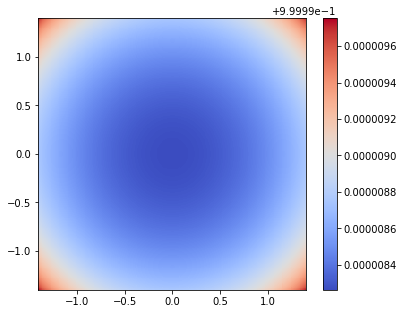

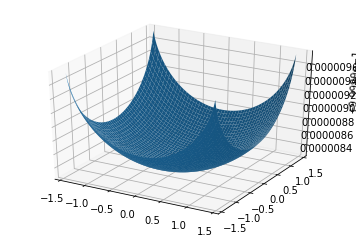

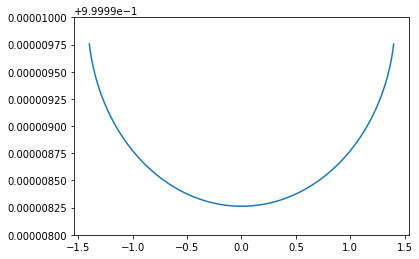

In [5]:
# Run code

E = 5928.44775 # eV

sampling_params = [-1.4, 1.4, -1.4, 1.4, 300, 300]
R = 2
intensity = 1
distance = 1
h = 6.64*(10**(-34))
c = 299792458

# n-Heptane values
delta = 1.51026588E-05
beta  = 3.45463604E-08
nu1    = 1
nu2    = 1 - delta
r     = nu1 / nu2
lambda_0 = h*c/E

data = create_matrix(sampling_params, R, nu1, nu2)
data2 = screen(intensity, data, distance, beta, R, sampling_params)
plot_intensity(data2, sampling_params)